In [1]:
# =========================================
# Importy - wszystkie w jednym miejscu
# =========================================

# Podstawowe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output
import difflib
import io, os, base64
import unicodedata
from datetime import datetime


# Sklearn - podział danych, modele, metryki, pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error,
    ConfusionMatrixDisplay
)

# SHAP - interpretacja modeli
import shap

# Ostrzeżenia
import warnings
warnings.filterwarnings("ignore")

In [8]:
# === Sekcja 2 — Wczytanie danych z CSV (bezpieczna wersja) ===

CSV_FILE = "data.csv"

if os.path.exists(CSV_FILE):
    data_all = pd.read_csv(CSV_FILE)
    print(f"✅ Załadowano plik: {CSV_FILE}")
    print("🔎 Kolumny:", list(data_all.columns))
    print("\n📊 Podgląd danych (pierwsze 5 wierszy):")
    display(data_all.head())
else:
    raise FileNotFoundError(f"❌ Nie znaleziono pliku {CSV_FILE}. Upewnij się, że jest w tym samym katalogu co notebook.")


✅ Załadowano plik: data.csv
🔎 Kolumny: ['Country', 'Year', 'Total Water Consumption (Billion Cubic Meters)', 'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)', 'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)', 'Water Scarcity Level']

📊 Podgląd danych (pierwsze 5 wierszy):


,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [3]:
# =========================================
# Sekcja 3: Przygotowanie danych
# =========================================

# Wczytaj dane
data = pd.read_csv("data.csv")

# Zmienna celu dla klasyfikacji
y_class = data["Water Scarcity Level"]

# Zmienne celu dla regresji
y_reg1 = data["Total Water Consumption (Billion Cubic Meters)"]
y_reg2 = data["Per Capita Water Use (Liters per Day)"]

# Zmienne wejściowe (bez kolumn celu)
X = data.drop([
    "Water Scarcity Level",
    "Total Water Consumption (Billion Cubic Meters)",
    "Per Capita Water Use (Liters per Day)"
], axis=1)

# Podgląd
display(X.head(), y_class.head())


,Country,Year,Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%)
0,Argentina,2000,48.550000,20.844286,30.100000,1288.698571,3.255714
1,Argentina,2001,48.465000,26.943000,22.550000,1371.729000,3.120000
2,Argentina,2002,50.375385,29.042308,23.349231,1590.305385,2.733846
3,Argentina,2003,49.086667,30.476000,24.440000,1816.012667,2.708000
4,Argentina,2004,38.670000,36.670000,23.924000,815.998000,1.902000


0    Moderate
1    Moderate
2    Moderate
3    Moderate
4    Moderate
Name: Water Scarcity Level, dtype: object

In [4]:
# =========================================
# Sekcja 4: Trenowanie modeli
# =========================================

# --- Podział danych ---
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

Xr1_train, Xr1_test, yr1_train, yr1_test = train_test_split(
    X, y_reg1, test_size=0.2, random_state=42
)

Xr2_train, Xr2_test, yr2_train, yr2_test = train_test_split(
    X, y_reg2, test_size=0.2, random_state=42
)

# --- Pipeline dla klasyfikatora ---
cat_features = ["Country"]  # kolumny kategoryczne
num_features = [col for col in X.columns if col not in cat_features]

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", StandardScaler(), num_features)
])

clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

clf.fit(X_train, y_train_class)

# --- Pipeline dla regresorów ---
reg1 = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

reg2 = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

reg1.fit(Xr1_train, yr1_train)
reg2.fit(Xr2_train, yr2_train)

print("✅ Modele wytrenowane")


✅ Modele wytrenowane


Obliczanie SHAP dla klasyfikatora (może potrwać)...


  0%|          | 0/100 [00:00<?, ?it/s]

Wykres SHAP dla klasy: High  (sv=(26, 3), X=(26, 3))


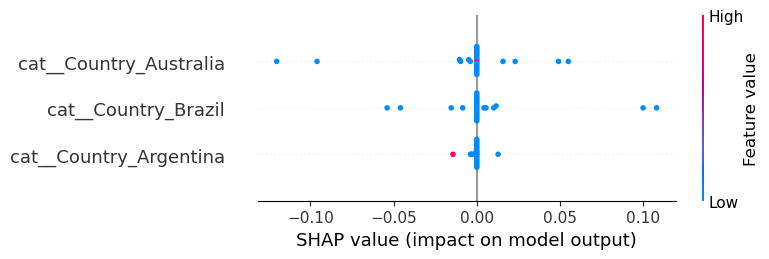

Wykres SHAP dla klasy: Low  (sv=(26, 3), X=(26, 3))


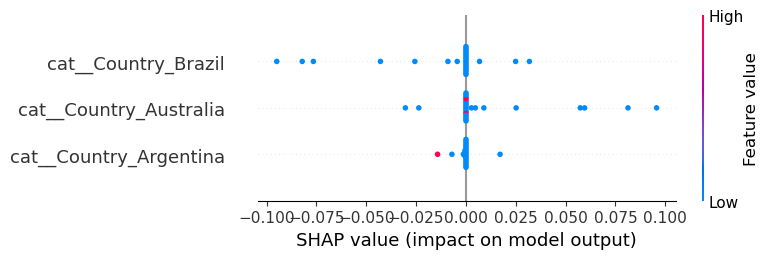

Wykres SHAP dla klasy: Moderate  (sv=(26, 3), X=(26, 3))


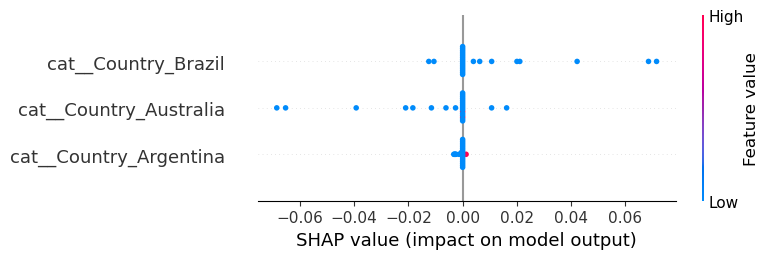

Obliczanie SHAP dla Regresora 1 (Total Water Consumption)...


  0%|          | 0/100 [00:00<?, ?it/s]

Reg1 SHAP: sv=(100, 26), X=(100, 26)


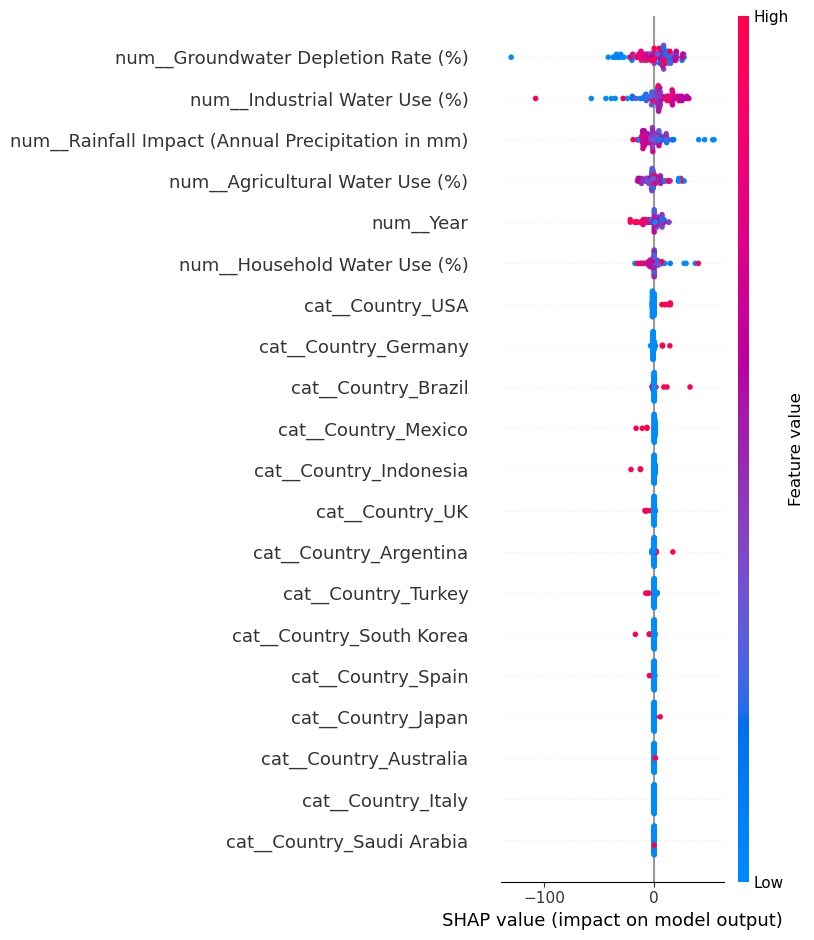

Obliczanie SHAP dla Regresora 2 (Per Capita Water Use)...


  0%|          | 0/100 [00:00<?, ?it/s]

Reg2 SHAP: sv=(100, 26), X=(100, 26)


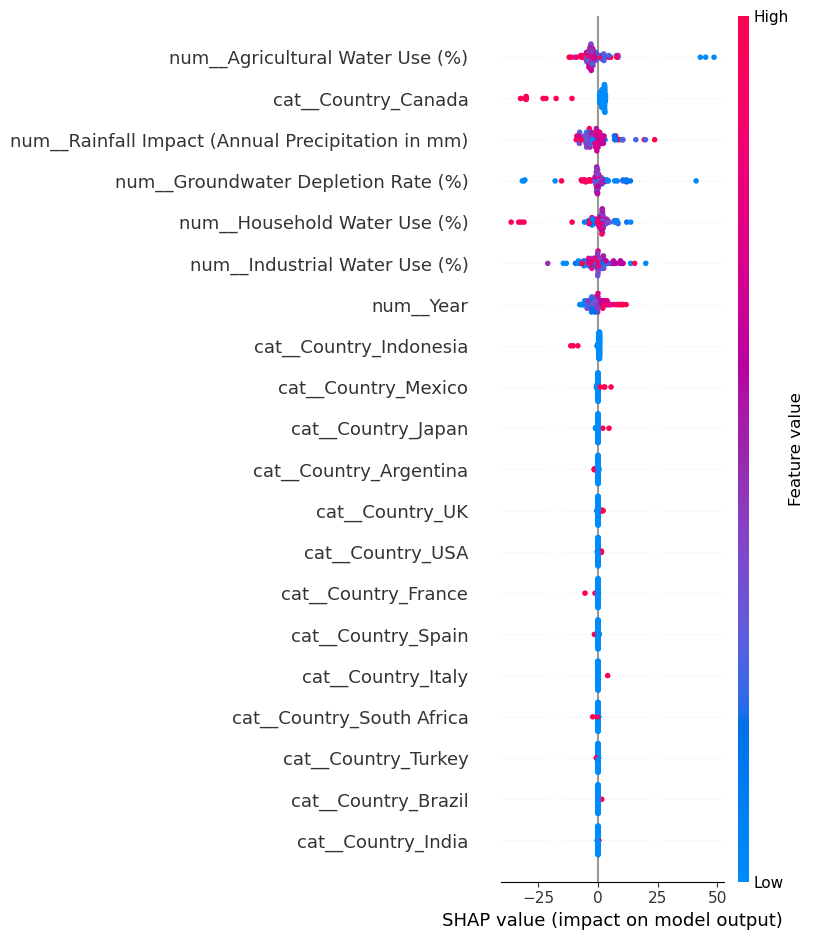

In [5]:
# =========================================
# Sekcja 5: Analiza SHAP – KernelExplainer + solidne wyrównanie wymiarów
# =========================================

def _to_dense(A):
    return A.toarray() if hasattr(A, "toarray") else np.asarray(A)

def _align_shap_and_X(sv, X_dense, feat_names):
    """
    Wyrównuje kształty SHAP (sv) i cech (X_dense), łącznie z:
    - zamianą list -> ndarray,
    - transpozycją, jeśli zwrócono (n_features, n_samples),
    - obcięciem ewentualnej kolumny offsetu,
    - dopasowaniem liczby wierszy (n_samples) i kolumn (n_features).
    Zwraca: (sv_aligned, X_aligned, feat_aligned)
    """
    sv = np.array(sv)

    # Jeśli SHAP ma układ (n_features, n_samples) -> zamień na (n_samples, n_features)
    if sv.ndim == 2 and sv.shape[0] == X_dense.shape[1] and sv.shape[1] == X_dense.shape[0]:
        sv = sv.T

    # Jeśli jest 1D: (n_features,) -> (1, n_features)
    if sv.ndim == 1:
        sv = sv.reshape(1, -1)

    # Przytnij offset (n_features + 1) jeśli jest
    if sv.shape[1] == X_dense.shape[1] + 1:
        sv = sv[:, :-1]

    # Ustaw wspólną liczbę wierszy (n_samples)
    r = min(sv.shape[0], X_dense.shape[0])
    sv = sv[:r, :]
    X_use = X_dense[:r, :]

    # Ustaw wspólną liczbę kolumn (n_features)
    c = min(sv.shape[1], X_use.shape[1], len(feat_names))
    sv = sv[:, :c]
    X_use = X_use[:, :c]
    feat_use = np.asarray(feat_names)[:c]

    return sv, X_use, feat_use


print("Obliczanie SHAP dla klasyfikatora (może potrwać)...")

# ---------- KLASYFIKATOR ----------
X_transformed = clf.named_steps["prep"].transform(X_test)
feature_names = clf.named_steps["prep"].get_feature_names_out()
X_dense = _to_dense(X_transformed)

# tło dla KernelExplainer (losowe <=50)
n_bg_clf = min(50, X_dense.shape[0])
idx_bg = np.random.choice(X_dense.shape[0], n_bg_clf, replace=False)
background_clf = X_dense[idx_bg, :]

explainer_clf = shap.KernelExplainer(
    clf.named_steps["model"].predict_proba,
    background_clf
)

# SHAP values (lista: po klasach)
shap_values_clf = explainer_clf.shap_values(X_dense)

for i, class_name in enumerate(clf.named_steps["model"].classes_):
    sv = shap_values_clf[i]
    sv, X_plot, feat_plot = _align_shap_and_X(sv, X_dense, feature_names)
    print(f"Wykres SHAP dla klasy: {class_name}  (sv={sv.shape}, X={X_plot.shape})")
    shap.summary_plot(sv, X_plot, feature_names=feat_plot, show=True)
    plt.show()


# ---------- REGRESOR 1: Total Water Consumption ----------
print("Obliczanie SHAP dla Regresora 1 (Total Water Consumption)...")
Xr1_transformed = reg1.named_steps["prep"].transform(Xr1_test)
feat_r1 = reg1.named_steps["prep"].get_feature_names_out()
Xr1_dense = _to_dense(Xr1_transformed)

n_bg_r1 = min(50, Xr1_dense.shape[0])
idx_bg_r1 = np.random.choice(Xr1_dense.shape[0], n_bg_r1, replace=False)
background_r1 = Xr1_dense[idx_bg_r1, :]

explainer_r1 = shap.KernelExplainer(
    reg1.named_steps["model"].predict,
    background_r1
)
shap_values_r1 = explainer_r1.shap_values(Xr1_dense)

sv1, Xr1_plot, feat_r1_plot = _align_shap_and_X(shap_values_r1, Xr1_dense, feat_r1)
print(f"Reg1 SHAP: sv={sv1.shape}, X={Xr1_plot.shape}")
shap.summary_plot(sv1, Xr1_plot, feature_names=feat_r1_plot, show=True)
plt.show()


# ---------- REGRESOR 2: Per Capita Water Use ----------
print("Obliczanie SHAP dla Regresora 2 (Per Capita Water Use)...")
Xr2_transformed = reg2.named_steps["prep"].transform(Xr2_test)
feat_r2 = reg2.named_steps["prep"].get_feature_names_out()
Xr2_dense = _to_dense(Xr2_transformed)

n_bg_r2 = min(50, Xr2_dense.shape[0])
idx_bg_r2 = np.random.choice(Xr2_dense.shape[0], n_bg_r2, replace=False)
background_r2 = Xr2_dense[idx_bg_r2, :]

explainer_r2 = shap.KernelExplainer(
    reg2.named_steps["model"].predict,
    background_r2
)
shap_values_r2 = explainer_r2.shap_values(Xr2_dense)

sv2, Xr2_plot, feat_r2_plot = _align_shap_and_X(shap_values_r2, Xr2_dense, feat_r2)
print(f"Reg2 SHAP: sv={sv2.shape}, X={Xr2_plot.shape}")
shap.summary_plot(sv2, Xr2_plot, feature_names=feat_r2_plot, show=True)
plt.show()


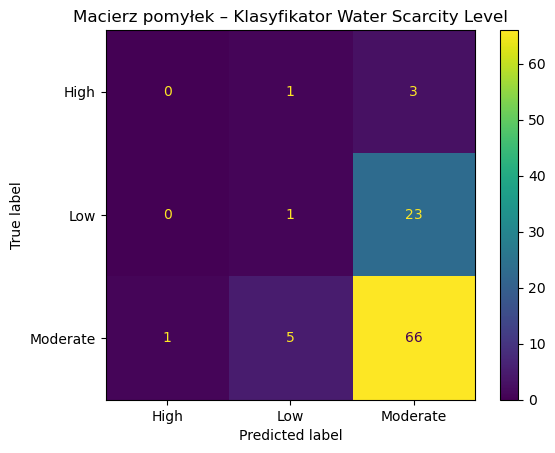

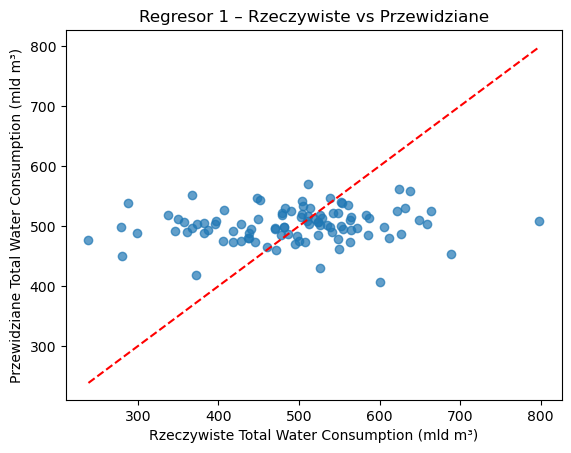

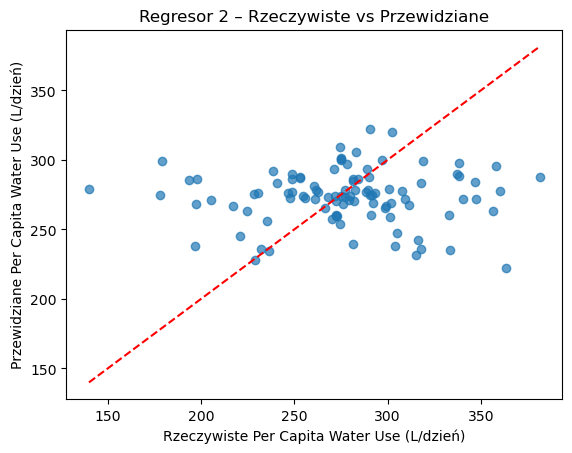

In [6]:
# =========================================
# Sekcja 6: Dodatkowe wykresy i analiza porównawcza
# =========================================

# Macierz pomyłek dla klasyfikatora
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test_class)
plt.title("Macierz pomyłek – Klasyfikator Water Scarcity Level")
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.show()

# Wykres rzeczywiste vs przewidziane – Regresor 1
y_pred_r1 = reg1.predict(Xr1_test)
plt.scatter(yr1_test, y_pred_r1, alpha=0.7)
plt.xlabel("Rzeczywiste Total Water Consumption (mld m³)")
plt.ylabel("Przewidziane Total Water Consumption (mld m³)")
plt.title("Regresor 1 – Rzeczywiste vs Przewidziane")
plt.plot([yr1_test.min(), yr1_test.max()], [yr1_test.min(), yr1_test.max()], 'r--')
plt.savefig("reg1_actual_vs_pred.png", bbox_inches="tight")
plt.show()

# Wykres rzeczywiste vs przewidziane – Regresor 2
y_pred_r2 = reg2.predict(Xr2_test)
plt.scatter(yr2_test, y_pred_r2, alpha=0.7)
plt.xlabel("Rzeczywiste Per Capita Water Use (L/dzień)")
plt.ylabel("Przewidziane Per Capita Water Use (L/dzień)")
plt.title("Regresor 2 – Rzeczywiste vs Przewidziane")
plt.plot([yr2_test.min(), yr2_test.max()], [yr2_test.min(), yr2_test.max()], 'r--')
plt.savefig("reg2_actual_vs_pred.png", bbox_inches="tight")
plt.show()


In [9]:
# === Sekcja 7 — Minimalne utils (STRICT) ===
# Użycie:
#   available = get_available_countries(data_all) 
#   df_country = select_country_strict(data_all, "USA")

def get_available_countries(df, country_col: str = "Country"):
    """Zwraca posortowaną listę nazw krajów dokładnie tak, jak występują w CSV."""
    if country_col not in df.columns:
        raise KeyError(f"Brak kolumny '{country_col}' w danych. Dostępne: {list(df.columns)}")
    return sorted(df[country_col].dropna().astype(str).unique().tolist())

def select_country_strict(df, country_name: str, country_col: str = "Country"):
    """Zwraca wiersze dla dokładnie podanej nazwy kraju.
       Rzuca ValueError, jeśli nazwa nie występuje w danych."""
    allowed = get_available_countries(df, country_col)
    if country_name not in allowed:
        raise ValueError(
            "❌ Nie znaleziono kraju '{0}' w danych.\n"
            "➡️ Użyj jednej z dostępnych nazw: {1}".format(country_name, ", ".join(allowed))
        )
    out = df[df[country_col] == country_name].copy()
    out.attrs["matched_country"] = country_name
    return out


In [9]:
# === Sekcja 8 — Tryb ścisły: pełna lista krajów + bezpieczne widżety ===

# 1) Pełna lista krajów dokładnie tak, jak w CSV
all_countries = sorted(
    pd.Series(data_all["Country"].dropna().astype(str).unique()).tolist()
)

print(f"🌍 Dostępne kraje w pliku CSV (łącznie {len(all_countries)}):")
for i, c in enumerate(all_countries, start=1):
    print(f"{i:2d}. {c}")

if not all_countries:
    raise ValueError("Brak krajów w danych — sprawdź kolumnę 'Country'.")

# 2) Mapa: kraj -> dostępne lata
if "Year" not in data_all.columns:
    raise KeyError("Brak kolumny 'Year' — ta sekcja jej wymaga.")

years_by_country = {
    c: sorted(data_all.loc[data_all["Country"] == c, "Year"].dropna().unique().tolist())
    for c in all_countries
}

# 3) Startowe, zawsze poprawne wartości (bez wpisywania 'Poland')
default_country = all_countries[0]
default_years = years_by_country.get(default_country, [])
default_year = default_years[-1] if default_years else None

country_select = widgets.Dropdown(
    options=all_countries,
    value=default_country,      # ważne: wartość musi być w options
    description="Kraj",
)

year_select = widgets.Dropdown(
    options=default_years,
    value=default_year if default_year is not None else None,
    description="Rok",
)

forecast_years_slider = widgets.IntSlider(
    value=5, min=1, max=20, step=1, description="Lata prognozy"
)

out = widgets.Output()

def on_country_change(change):
    if change["name"] == "value":
        sel = change["new"]
        yrs = years_by_country.get(sel, [])
        year_select.options = yrs
        year_select.value = yrs[-1] if yrs else None

country_select.observe(on_country_change, names="value")

def on_any_change(change=None):
    with out:
        out.clear_output()
        country = country_select.value
        year = year_select.value
        horizon = forecast_years_slider.value

        if country is None or year is None:
            print("⚠️ Wybierz kraj i rok (brak danych dla kombinacji).")
            return

        # STRICT: filtr dokładny po nazwie z CSV
        df_c = data_all[data_all["Country"] == country].sort_values("Year").copy()
        row = df_c[df_c["Year"] == year]
        if row.empty:
            print("⚠️ Brak wiersza dla wybranego roku — wybierz inny rok.")
            return

        display(row)
        print(f"ℹ️ Kraj: {country} | Rok startowy: {year} | Horyzont prognozy: {horizon} lat")
        # <- tutaj podepnij swoją funkcję predykcji/wykres/eksport, jeśli już masz

# Pierwsze odświeżenie
on_any_change(None)

# Reakcje na zmianę roku/horyzontu
year_select.observe(on_any_change, names="value")
forecast_years_slider.observe(on_any_change, names="value")

ui = widgets.VBox([widgets.HBox([country_select, year_select, forecast_years_slider]), out])
display(ui)


🌍 Dostępne kraje w pliku CSV (łącznie 20):
 1. Argentina
 2. Australia
 3. Brazil
 4. Canada
 5. China
 6. France
 7. Germany
 8. India
 9. Indonesia
10. Italy
11. Japan
12. Mexico
13. Russia
14. Saudi Arabia
15. South Africa
16. South Korea
17. Spain
18. Turkey
19. UK
20. USA


In [10]:
# === Sekcja 9 — Wykres trendu + Eksport CSV/PNG (strict; korzysta z widżetów z Sekcji 8) ===

# Kolumna domyślna do wykresu (jeśli nie istnieje, skrypt spróbuje znaleźć pierwszą numeryczną inną niż 'Year')
VALUE_COL_PREFERRED = "Total Water Consumption (Billion Cubic Meters)"

plot_out = widgets.Output()
export_out = widgets.Output()
btn_csv = widgets.Button(description="Eksportuj CSV", icon="save")
btn_png = widgets.Button(description="Eksportuj PNG", icon="image")

def _pick_value_col(df):
    """Wybór kolumny do wykresu: preferowana, a jeśli brak — pierwsza numeryczna != 'Year'."""
    if VALUE_COL_PREFERRED in df.columns:
        return VALUE_COL_PREFERRED
    # szukaj pierwszej sensownej numerycznej kolumny
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "Year"]
    if not num_cols:
        raise KeyError("Brak numerycznych kolumn do wykresu (poza 'Year').")
    return num_cols[0]

def _get_country_df(country: str):
    df_c = data_all[data_all["Country"] == country].copy()
    if df_c.empty:
        raise ValueError(f"Brak danych dla kraju: {country}")
    if "Year" not in df_c.columns:
        raise KeyError("Brak kolumny 'Year' w danych.")
    df_c = df_c.dropna(subset=["Year"]).sort_values("Year")
    return df_c

def _make_forecast(years, values, horizon: int):
    """Prosty forecast liniowy (polyfit deg=1). Zwraca (future_years, future_values)."""
    if horizon <= 0 or len(years) < 2:
        return [], []
    # Model liniowy: y = a*x + b
    a, b = np.polyfit(np.array(years, dtype=float), np.array(values, dtype=float), deg=1)
    last_year = int(max(years))
    future_years = list(range(last_year + 1, last_year + 1 + horizon))
    future_values = [a*y + b for y in future_years]
    return future_years, future_values

def _current_selection():
    country = country_select.value
    horizon = int(forecast_years_slider.value)
    return country, horizon

def refresh_plot_and_preview(*args):
    with plot_out:
        plot_out.clear_output()
        try:
            country, horizon = _current_selection()
            df_c = _get_country_df(country)
            value_col = _pick_value_col(df_c)

            years = df_c["Year"].tolist()
            vals  = df_c[value_col].astype(float).tolist()

            # Forecast (prosta linia) — opcjonalnie
            f_years, f_vals = _make_forecast(years, vals, horizon)

            # Rysuj
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(7, 4))
            ax.plot(years, vals, marker="o", label=f"Historia — {value_col}")
            if f_years:
                ax.plot(f_years, f_vals, marker="o", linestyle="--", label=f"Prognoza (+{horizon} lat)")
            ax.set_xlabel("Year")
            ax.set_ylabel(value_col)
            ax.set_title(f"Trend zużycia wody — {country}")
            ax.grid(True, linestyle=":")
            ax.legend()
            fig.tight_layout()
            plt.show()

            # Podgląd bieżącego wiersza (dla roku wybranego w Sekcji 8, jeśli istnieje)
            sel_year = year_select.value
            if sel_year is not None:
                row = df_c[df_c["Year"] == sel_year]
                if not row.empty:
                    display(row)
        except Exception as e:
            print("❌ Błąd podczas rysowania:", e)

def _export_csv(*args):
    with export_out:
        export_out.clear_output()
        try:
            country, horizon = _current_selection()
            df_c = _get_country_df(country)
            value_col = _pick_value_col(df_c)

            years = df_c["Year"].tolist()
            vals  = df_c[value_col].astype(float).tolist()
            f_years, f_vals = _make_forecast(years, vals, horizon)

            # Przygotuj DataFrame do eksportu (historia + prognoza)
            df_export = df_c[["Year", value_col]].copy()
            if f_years:
                df_fc = pd.DataFrame({"Year": f_years, value_col: f_vals})
                df_export = pd.concat([df_export, df_fc], ignore_index=True)

            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            fname = f"water_{country.replace(' ', '_')}_{ts}.csv"
            df_export.to_csv(fname, index=False)
            print(f"✅ Zapisano CSV: {fname}")
        except Exception as e:
            print("❌ Błąd eksportu CSV:", e)

def _export_png(*args):
    with export_out:
        export_out.clear_output()
        try:
            country, horizon = _current_selection()
            df_c = _get_country_df(country)
            value_col = _pick_value_col(df_c)

            years = df_c["Year"].tolist()
            vals  = df_c[value_col].astype(float).tolist()
            f_years, f_vals = _make_forecast(years, vals, horizon)

            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(9, 5))
            ax.plot(years, vals, marker="o", label=f"Historia — {value_col}")
            if f_years:
                ax.plot(f_years, f_vals, marker="o", linestyle="--", label=f"Prognoza (+{horizon} lat)")
            ax.set_xlabel("Year")
            ax.set_ylabel(value_col)
            ax.set_title(f"Trend zużycia wody — {country}")
            ax.grid(True, linestyle=":")
            ax.legend()
            fig.tight_layout()

            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            fname = f"water_{country.replace(' ', '_')}_{ts}.png"
            fig.savefig(fname, dpi=160)
            plt.close(fig)
            print(f"✅ Zapisano PNG: {fname}")
        except Exception as e:
            print("❌ Błąd eksportu PNG:", e)

# Podpinka zdarzeń
btn_csv.on_click(_export_csv)
btn_png.on_click(_export_png)

# Odświeżanie wykresu, gdy użytkownik coś zmieni (kraj/rok/horyzont)
country_select.observe(refresh_plot_and_preview, names="value")
year_select.observe(refresh_plot_and_preview, names="value")
forecast_years_slider.observe(refresh_plot_and_preview, names="value")

# UI
controls = widgets.HBox([btn_csv, btn_png])
ui9 = widgets.VBox([controls, plot_out, export_out])
display(ui9)

# Inicjalny render
refresh_plot_and_preview()


In [29]:
# === Sekcja 10 — Metryki trendu (YoY, MA, CAGR) + eksport CSV ===


# Preferowana kolumna wartości (jak w Sekcji 9); jeśli nie istnieje, zostanie dobrana pierwsza numeryczna ≠ 'Year'
VALUE_COL_PREFERRED_10 = "Total Water Consumption (Billion Cubic Meters)"

# Kontrolki Sekcji 10
metrics_out = widgets.Output()
ma_slider = widgets.IntSlider(value=3, min=2, max=10, step=1, description="MA (lata)")
cagr_slider = widgets.IntSlider(value=5, min=2, max=15, step=1, description="CAGR (lata)")
btn_export_metrics = widgets.Button(description="Eksportuj METRYKI CSV", icon="save")

def _pick_value_col_10(df):
    if VALUE_COL_PREFERRED_10 in df.columns:
        return VALUE_COL_PREFERRED_10
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "Year"]
    if not num_cols:
        raise KeyError("Brak numerycznych kolumn do metryk (poza 'Year').")
    return num_cols[0]

def _get_country_df_10(country: str):
    df_c = data_all[data_all["Country"] == country].copy()
    if df_c.empty:
        raise ValueError(f"Brak danych dla kraju: {country}")
    if "Year" not in df_c.columns:
        raise KeyError("Brak kolumny 'Year' w danych.")
    df_c = df_c.dropna(subset=["Year"]).sort_values("Year")
    return df_c

def _compute_metrics(df_c, value_col, ma_w: int, cagr_n: int):
    s = df_c[value_col].astype(float).reset_index(drop=True)
    years = df_c["Year"].astype(int).tolist()
    yoy_pct = s.pct_change() * 100.0
    ma = s.rolling(ma_w, min_periods=1).mean()

    df_m = pd.DataFrame({
        "Year": years,
        value_col: s,
        "YoY %": yoy_pct,
        f"MA{ma_w}": ma
    })

    # CAGR z końcówki szeregu (ostatnie ~cagr_n lat; jeśli brak dokładnych lat, bierzemy n+1 ostatnich punktów)
    cagr_val = np.nan
    if len(s) >= (cagr_n + 1):
        last_year = years[-1]
        target_start_year = last_year - cagr_n
        if target_start_year in years:
            idx_start = years.index(target_start_year)
        else:
            idx_start = max(0, len(s) - 1 - cagr_n)
        v_start, v_end = float(s.iloc[idx_start]), float(s.iloc[-1])
        n_years = years[-1] - years[idx_start]
        if v_start > 0 and n_years > 0:
            cagr_val = (v_end / v_start) ** (1.0 / n_years) - 1.0

    return df_m, cagr_val

def refresh_metrics(_=None):
    with metrics_out:
        metrics_out.clear_output()
        try:
            country = country_select.value
            df_c = _get_country_df_10(country)
            value_col = _pick_value_col_10(df_c)
            ma_w = int(ma_slider.value)
            cagr_n = int(cagr_slider.value)

            df_m, cagr_val = _compute_metrics(df_c, value_col, ma_w, cagr_n)
            display(df_m)

            # Podsumowanie ostatniego roku
            last_year = int(df_c["Year"].iloc[-1])
            last_val = float(df_c[value_col].iloc[-1])
            if len(df_c) >= 2 and float(df_c[value_col].iloc[-2]) > 0:
                yoy_last = (last_val / float(df_c[value_col].iloc[-2]) - 1.0) * 100.0
            else:
                yoy_last = np.nan

            print(f"📌 {country} — {value_col}")
            print(f"  Ostatni rok: {last_year} | Wartość: {last_val:,.2f}")
            if not np.isnan(yoy_last):
                print(f"  Zmiana r/r: {yoy_last:+.2f}%")
            if not np.isnan(cagr_val):
                print(f"  CAGR (ostatnie ~{cagr_n} lat): {cagr_val*100:.2f}%")
        except Exception as e:
            print("❌ Błąd metryk:", e)

def _export_metrics(_):
    with metrics_out:
        try:
            country = country_select.value
            df_c = _get_country_df_10(country)
            value_col = _pick_value_col_10(df_c)
            ma_w = int(ma_slider.value)
            cagr_n = int(cagr_slider.value)
            df_m, _ = _compute_metrics(df_c, value_col, ma_w, cagr_n)
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            fname = f"metrics_{country.replace(' ', '_')}_{ts}.csv"
            df_m.to_csv(fname, index=False)
            print(f"✅ Zapisano metryki do: {fname}")
        except Exception as e:
            print("❌ Błąd eksportu metryk:", e)

# Zdarzenia
btn_export_metrics.on_click(_export_metrics)
for w in (country_select, year_select, ma_slider, cagr_slider):
    w.observe(refresh_metrics, names="value")

# UI Sekcji 10
controls10 = widgets.HBox([ma_slider, cagr_slider, btn_export_metrics])
ui10 = widgets.VBox([controls10, metrics_out])
display(ui10)

# Startowy render
refresh_metrics()


In [11]:
# === Sekcja 11 — Prosta prognoza ML (LinearRegression) ===


ml_out = widgets.Output()
btn_train_predict = widgets.Button(description="Trenuj model i prognozuj", icon="play")

VALUE_COL_PREFERRED_11 = "Total Water Consumption (Billion Cubic Meters)"

def _pick_value_col_11(df):
    if VALUE_COL_PREFERRED_11 in df.columns:
        return VALUE_COL_PREFERRED_11
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "Year"]
    if not num_cols:
        raise KeyError("Brak numerycznych kolumn do prognozy ML (poza 'Year').")
    return num_cols[0]

def _train_and_predict(country: str, horizon: int):
    df_c = data_all[data_all["Country"] == country].dropna(subset=["Year"]).copy()
    df_c = df_c.sort_values("Year")
    if df_c.empty:
        raise ValueError(f"Brak danych dla kraju: {country}")
    value_col = _pick_value_col_11(df_c)

    X = df_c[["Year"]].values.astype(float)
    y = df_c[value_col].values.astype(float)

    model = LinearRegression()
    model.fit(X, y)

    last_year = int(df_c["Year"].iloc[-1])
    future_years = np.arange(last_year + 1, last_year + 1 + horizon).reshape(-1, 1)
    y_pred_future = model.predict(future_years)

    return df_c, value_col, model, future_years.ravel().astype(int), y_pred_future

def _on_train_predict(_=None):
    with ml_out:
        ml_out.clear_output()
        try:
            country = country_select.value
            horizon = int(forecast_years_slider.value)
            df_c, value_col, model, f_years, f_preds = _train_and_predict(country, horizon)

            # Wskaźnik dopasowania na danych historycznych
            r2 = model.score(df_c[["Year"]].values, df_c[value_col].values)

            print(f"📊 Model ML (LinearRegression) dla kraju: {country}")
            print(f"   Wskaźnik R² na danych historycznych: {r2:.3f}")
            print(f"   Prognoza na kolejne {horizon} lat:")

            df_pred = pd.DataFrame({"Year": f_years, f"Forecast {value_col}": f_preds})
            display(df_pred)

            # Wykres
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(7,4))
            ax.plot(df_c["Year"], df_c[value_col], marker="o", label="Historia")
            ax.plot(f_years, f_preds, marker="o", linestyle="--", label="Prognoza (ML)")
            ax.set_xlabel("Year")
            ax.set_ylabel(value_col)
            ax.set_title(f"Prognoza ML — {country}")
            ax.legend()
            ax.grid(True, linestyle=":")
            plt.show()
        except Exception as e:
            print("❌ Błąd prognozy ML:", e)

btn_train_predict.on_click(_on_train_predict)

ui11 = widgets.VBox([btn_train_predict, ml_out])
display(ui11)


In [12]:
# === Sekcja 12 — Porównanie forecastu liniowego (polyfit) i ML (LinearRegression) ===

compare_out = widgets.Output()
btn_compare = widgets.Button(description="Porównaj prognozy (Polyfit vs ML)", icon="refresh")

def _compare_forecasts(country: str, horizon: int):
    df_c = data_all[data_all["Country"] == country].dropna(subset=["Year"]).copy()
    df_c = df_c.sort_values("Year")
    if df_c.empty:
        raise ValueError(f"Brak danych dla kraju: {country}")
    value_col = _pick_value_col_11(df_c)

    # --- Forecast polyfit (Sekcja 9)
    years = df_c["Year"].tolist()
    vals = df_c[value_col].astype(float).tolist()
    f_years_poly, f_vals_poly = _make_forecast(years, vals, horizon)

    # --- Forecast ML (Sekcja 11)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(df_c[["Year"]].values.astype(float), df_c[value_col].values.astype(float))
    f_years_ml = np.arange(df_c["Year"].iloc[-1] + 1, df_c["Year"].iloc[-1] + 1 + horizon).reshape(-1, 1)
    f_vals_ml = model.predict(f_years_ml)

    return df_c, value_col, f_years_poly, f_vals_poly, f_years_ml.ravel().astype(int), f_vals_ml

def _on_compare(_=None):
    with compare_out:
        compare_out.clear_output()
        try:
            country = country_select.value
            horizon = int(forecast_years_slider.value)
            df_c, value_col, fy_poly, fv_poly, fy_ml, fv_ml = _compare_forecasts(country, horizon)

            print(f"📊 Porównanie prognoz dla kraju: {country} | Kolumna: {value_col}")
            # Tabelka porównawcza
            df_cmp = pd.DataFrame({
                "Year": fy_poly,
                "Polyfit forecast": fv_poly,
                "ML forecast": fv_ml
            })
            display(df_cmp)

            # Wykres
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(8,5))
            ax.plot(df_c["Year"], df_c[value_col], marker="o", label="Historia")
            ax.plot(fy_poly, fv_poly, marker="o", linestyle="--", label="Prognoza (polyfit)")
            ax.plot(fy_ml, fv_ml, marker="s", linestyle="--", label="Prognoza (ML)")
            ax.set_xlabel("Year")
            ax.set_ylabel(value_col)
            ax.set_title(f"Porównanie prognoz — {country}")
            ax.legend()
            ax.grid(True, linestyle=":")
            plt.show()
        except Exception as e:
            print("❌ Błąd porównania:", e)

btn_compare.on_click(_on_compare)

ui12 = widgets.VBox([btn_compare, compare_out])
display(ui12)


In [13]:
# === Sekcja 13 — Raport HTML (historia, metryki, prognozy, wykresy) — FIX ===

def _r13_pick_value_col(df, preferred="Total Water Consumption (Billion Cubic Meters)"):
    if preferred in df.columns:
        return preferred
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "Year"]
    if not num_cols:
        raise KeyError("Brak numerycznych kolumn do raportu (poza 'Year').")
    return num_cols[0]

def _r13_get_country_df(country: str):
    if "Year" not in data_all.columns:
        raise KeyError("Brak kolumny 'Year' w danych.")
    df_c = data_all[data_all["Country"] == country].dropna(subset=["Year"]).copy()
    if df_c.empty:
        raise ValueError(f"Brak danych dla kraju: {country}")
    return df_c.sort_values("Year")

def _r13_make_forecast_polyfit(years, values, horizon: int):
    # forecast liniowy na bazie polyfit
    if horizon <= 0 or len(years) < 2:
        return [], []
    a, b = np.polyfit(np.array(years, dtype=float), np.array(values, dtype=float), deg=1)
    last_year = int(max(years))
    f_years = list(range(last_year + 1, last_year + 1 + horizon))
    f_vals  = [a*y + b for y in f_years]
    return f_years, f_vals

def _r13_try_ml_forecast(df_c, value_col, horizon: int):
    """Próbuje ML (LinearRegression). Jeśli brak sklearn — zwraca puste wyniki."""
    try:
        from sklearn.linear_model import LinearRegression
    except Exception:
        return None, None, None, None  # brak ML
    X = df_c[["Year"]].values.astype(float)
    y = df_c[value_col].values.astype(float)
    model = LinearRegression().fit(X, y)
    last_year = int(df_c["Year"].iloc[-1])
    f_years_ml = np.arange(last_year + 1, last_year + 1 + horizon).reshape(-1, 1)
    preds = model.predict(f_years_ml)
    r2 = float(model.score(X, y))
    return f_years_ml.ravel().astype(int), preds, model, r2

def _r13_metrics(df_c, value_col, ma_window=3, cagr_years=5):
    s = df_c[value_col].astype(float).reset_index(drop=True)
    years = df_c["Year"].astype(int).tolist()
    yoy = s.pct_change() * 100.0
    ma  = s.rolling(ma_window, min_periods=1).mean()
    cagr = np.nan
    if len(s) >= 2:
        last_year = years[-1]
        start_year = last_year - cagr_years
        if start_year in years:
            i0 = years.index(start_year)
        else:
            i0 = max(0, len(s) - 1 - cagr_years)
        v0, v1 = float(s.iloc[i0]), float(s.iloc[-1])
        n = years[-1] - years[i0]
        if v0 > 0 and n > 0:
            cagr = (v1 / v0) ** (1.0 / n) - 1.0
    df_m = pd.DataFrame({
        "Year": years,
        value_col: s,
        "YoY %": yoy,
        f"MA{ma_window}": ma
    })
    return df_m, cagr

def _r13_fig_to_base64(fig):
    import matplotlib.pyplot as plt
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=160, bbox_inches="tight")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

def _r13_plot_trend(df_c, value_col, f_years_poly, f_vals_poly, country, horizon):
    import matplotlib.pyplot as plt
    years = df_c["Year"].tolist()
    vals  = df_c[value_col].astype(float).tolist()
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.plot(years, vals, marker="o", label=f"Historia — {value_col}")
    if f_years_poly is not None and len(f_years_poly) > 0:
        ax.plot(f_years_poly, f_vals_poly, marker="o", linestyle="--", label=f"Prognoza (polyfit, +{horizon} lat)")
    ax.set_xlabel("Year"); ax.set_ylabel(value_col)
    ax.set_title(f"Trend zużycia wody — {country}")
    ax.grid(True, linestyle=":"); ax.legend()
    return _r13_fig_to_base64(fig)

def _r13_plot_compare(df_c, value_col, fy_poly, fv_poly, fy_ml, fv_ml, country):
    # UWAGA: fy_ml/fv_ml mogą być numpy.ndarray albo None — sprawdzamy długość jawnie
    if fy_ml is None or fv_ml is None:
        return None
    if len(fy_ml) == 0 or len(fv_ml) == 0:
        return None
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.plot(df_c["Year"], df_c[value_col], marker="o", label="Historia")
    if fy_poly is not None and len(fy_poly) > 0:
        ax.plot(fy_poly, fv_poly, marker="o", linestyle="--", label="Prognoza (polyfit)")
    ax.plot(fy_ml, fv_ml, marker="s", linestyle="--", label="Prognoza (ML)")
    ax.set_xlabel("Year"); ax.set_ylabel(value_col)
    ax.set_title(f"Porównanie prognoz — {country}")
    ax.grid(True, linestyle=":"); ax.legend()
    return _r13_fig_to_base64(fig)

def generate_report(country=None, horizon=None, ma_window=3, cagr_years=5, out_dir="reports"):
    os.makedirs(out_dir, exist_ok=True)

    # ustawienia domyślne z widżetów Sekcji 8
    if country is None:
        country = country_select.value
    if horizon is None:
        horizon = int(forecast_years_slider.value)

    df_c = _r13_get_country_df(country)
    value_col = _r13_pick_value_col(df_c)

    # metryki
    df_metrics, cagr = _r13_metrics(df_c, value_col, ma_window=ma_window, cagr_years=cagr_years)

    # prognozy
    years = df_c["Year"].tolist()
    vals  = df_c[value_col].astype(float).tolist()
    fy_poly, fv_poly = _r13_make_forecast_polyfit(years, vals, horizon)
    fy_ml, fv_ml, model, r2 = _r13_try_ml_forecast(df_c, value_col, horizon)

    # wykresy -> base64
    img_trend_b64   = _r13_plot_trend(df_c, value_col, fy_poly, fv_poly, country, horizon)
    img_compare_b64 = _r13_plot_compare(df_c, value_col, fy_poly, fv_poly, fy_ml, fv_ml, country)

    # tabele HTML
    hist_html = df_c[["Year", value_col]].to_html(index=False)
    metrics_html = df_metrics.to_html(index=False)

    comp_df = None
    if fy_poly is not None and len(fy_poly) > 0:
        comp_df = pd.DataFrame({"Year": fy_poly, "Polyfit forecast": fv_poly})
    if fy_ml is not None and fv_ml is not None and len(fy_ml) > 0:
        if comp_df is None:
            comp_df = pd.DataFrame({"Year": fy_ml, "ML forecast": fv_ml})
        else:
            # dopasuj długość kolumn, jeśli potrzeba
            df_ml = pd.DataFrame({"Year": fy_ml, "ML forecast": fv_ml})
            comp_df = pd.merge(comp_df, df_ml, on="Year", how="outer").sort_values("Year").reset_index(drop=True)

    comp_html = (comp_df.to_html(index=False) if comp_df is not None else "<em>Brak danych porównawczych.</em>")

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    fname = f"report_water_{country.replace(' ', '_')}_{ts}.html"
    fpath = os.path.join(out_dir, fname)

    html = f"""<!doctype html>
<html lang="pl">
<head>
<meta charset="utf-8">
<title>Raport — Zużycie wody — {country}</title>
<style>
body {{ font-family: Arial, sans-serif; margin: 24px; line-height: 1.5; }}
h1, h2 {{ margin: 0.2em 0; }}
section {{ margin-bottom: 28px; }}
.table-wrap {{ overflow-x: auto; }}
table {{ border-collapse: collapse; }}
th, td {{ border: 1px solid #ddd; padding: 6px 10px; }}
small {{ color: #555; }}
hr {{ border: none; border-top: 1px solid #eee; margin: 18px 0; }}
img {{ max-width: 100%; height: auto; }}
code {{ background: #f6f6f6; padding: 2px 4px; }}
</style>
</head>
<body>
  <h1>Raport — Zużycie wody</h1>
  <h2>{country}</h2>
  <small>Wygenerowano: {ts}</small>
  <hr/>

  <section>
    <h3>Podsumowanie</h3>
    <p>
      Kolumna analizowana: <code>{value_col}</code><br/>
      Horyzont prognozy: <b>{horizon}</b> lat<br/>
      CAGR (ostatnie ~{cagr_years} lat): <b>{'' if np.isnan(cagr) else f'{cagr*100:.2f}%'} </b><br/>
      R² (ML): <b>{'-' if r2 is None else f'{r2:.3f}'}</b>
    </p>
  </section>

  <section>
    <h3>Historia (Year, {value_col})</h3>
    <div class="table-wrap">{hist_html}</div>
  </section>

  <section>
    <h3>Metryki (YoY, MA{ma_window})</h3>
    <div class="table-wrap">{metrics_html}</div>
  </section>

  <section>
    <h3>Wykres trendu + prognoza (polyfit)</h3>
    <img alt="Trend" src="data:image/png;base64,{img_trend_b64}"/>
  </section>

  <section>
    <h3>Porównanie prognoz (polyfit vs ML)</h3>
    <div class="table-wrap">{comp_html}</div>
    {"<img alt='Porównanie prognoz' src='data:image/png;base64," + img_compare_b64 + "'/>" if img_compare_b64 is not None else "<em>ML niedostępny lub brak prognozy ML.</em>"}
  </section>

  <hr/>
  <small>Uwaga: prognozy mają charakter poglądowy (modele liniowe).</small>
</body>
</html>
"""
    with open(fpath, "w", encoding="utf-8") as f:
        f.write(html)

    print(f"✅ Raport zapisany: {fpath}")
    return fpath

# ===== UI: przycisk "Generuj raport" + podgląd ścieżki =====
r13_out = widgets.Output()
btn_report = widgets.Button(description="Generuj RAPORT (HTML)", icon="file")

def _on_report(_=None):
    with r13_out:
        r13_out.clear_output()
        try:
            path = generate_report()  # używa bieżących wyborów z Sekcji 8
            print("Gotowe:", path)
        except Exception as e:
            print("❌ Błąd generowania raportu:", e)

btn_report.on_click(_on_report)
display(widgets.VBox([btn_report, r13_out]))
